<a href="https://colab.research.google.com/github/HelBuk/CMF_Sber_hackathon/blob/main/%D0%A6%D0%9C%D0%A4_%D1%85%D0%B0%D0%BA%D0%B0%D1%82%D0%BE%D0%BD_%D1%81%D0%B1%D0%B5%D1%80_XGBoost_part_2_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import holidays as hld

In [124]:
orders = pd.read_csv('orders.csv')

In [ ]:
partners = pd.read_csv('partners_delays.csv')

In [125]:
#преобразуем столбец 'date' в datetime format
orders['date'] = pd.to_datetime(orders['date'])

In [ ]:
partners['dttm'] = pd.to_datetime(partners['dttm'])
partners = partners.set_index('dttm')

In [126]:
#Собираем уникальные delivery_area_id
unique_id = orders['delivery_area_id'].unique()

In [159]:
id_area = 0
df = orders[orders['delivery_area_id'] == id_area]
df

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2
...,...,...,...
2834,0,2021-11-30 17:00:00,10
2835,0,2021-11-30 18:00:00,21
2836,0,2021-11-30 19:00:00,10
2837,0,2021-11-30 20:00:00,15


In [160]:
#В DataFrame orders заменим индекты на даты
df = df.set_index('date')
#Добавляем строки, чтобы были данные по каждому часу
df = df.asfreq('H')
df

,delivery_area_id,orders_cnt
date,,
2021-04-01 10:00:00,0.0,9.0
2021-04-01 11:00:00,0.0,1.0
2021-04-01 12:00:00,NaN,NaN
2021-04-01 13:00:00,0.0,1.0
2021-04-01 14:00:00,0.0,1.0
...,...,...
2021-11-30 17:00:00,0.0,10.0
2021-11-30 18:00:00,0.0,21.0
2021-11-30 19:00:00,0.0,10.0


In [161]:
#Заполняем столбец "число заказов" там, где есть пропуски в данных
df['orders_cnt'] = df['orders_cnt'].interpolate()
df['delivery_area_id'] = id_area
df

,delivery_area_id,orders_cnt
date,,
2021-04-01 10:00:00,0,9.0
2021-04-01 11:00:00,0,1.0
2021-04-01 12:00:00,0,1.0
2021-04-01 13:00:00,0,1.0
2021-04-01 14:00:00,0,1.0
...,...,...
2021-11-30 17:00:00,0,10.0
2021-11-30 18:00:00,0,21.0
2021-11-30 19:00:00,0,10.0


In [162]:
#Список праздников в 2021
holidays = []
for i in range(1, 11):
  holidays.append(datetime(2021, 1, i).date())
for i in range(21, 24):
  holidays.append(datetime(2021, 2, i).date())
for i in range(6, 9):
  holidays.append(datetime(2021, 3, i).date())
for i in range(1, 4):
  holidays.append(datetime(2021, 5, i).date())
for i in range(8, 11):
  holidays.append(datetime(2021, 5, i).date())
for i in range(12, 15):
  holidays.append(datetime(2021, 6, i).date())
for i in range(4, 8):
  holidays.append(datetime(2021, 11, i).date())
holidays.append(datetime(2021, 12, 31).date())
Holidays = np.array([holidays])

In [262]:
def before_after_holiday(df): 
  df = df.copy()
  #выделим отдельный DataFrame только с датами
  df_dates = pd.Series(df.index, name="date").to_frame().sort_values(by='date')
  df_holidays = pd.DataFrame({'holidays': holidays})
  df_holidays['holidays'] = pd.to_datetime(df_holidays['holidays'])
  df_dates = pd.merge_asof(df_dates, df_holidays, left_on='date', right_on='holidays', direction='forward')
  df_dates = pd.merge_asof(df_dates, df_holidays, left_on='date', right_on='holidays')
  df_dates['days_until_holiday'] = df_dates.pop('holidays_x').sub(df_dates['date']).dt.days
  df_dates['days_since_holiday'] = df_dates['date'].sub(df_dates.pop('holidays_y')).dt.days
  df_dates = df_dates.drop_duplicates()
  df = pd.merge(df, df_dates, how='left', on='date')
  if df.index.name != 'date':
    #В DataFrame orders заменим индекты на даты
    df = df.set_index('date')
  #Добавляем строки, чтобы были данные по каждому часу
  df = df.asfreq('H')
  return df


In [164]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(np.int64)
    #Добавляем данные о праздниках (0/1)
    df['Holidays'] = np.array(list(map(lambda x: 1 if x in Holidays else 0, df.index.date)))
    #Добавляем отдельно столбец с единицей, если время вне интервала с 10:00 до 20:00
    df['early_late_h'] = np.array(list(map(lambda x: 1 if x in list(range(0, 10))+list(range(21, 24)) else 0,  df.index.hour)))
    #Если выходной, то 1
    df['weekend'] = np.array(list(map(lambda x: 1 if x in [5, 6] else 0, df.index.dayofweek)))
    return df

df = create_features(df)
df = before_after_holiday(df)

In [165]:
df

,delivery_area_id,orders_cnt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Holidays,early_late_h,weekend,days_until_holiday,days_since_holiday
date,,,,,,,,,,,,,,,
2021-04-01 10:00:00,0,9.0,10,3,2,4,2021,91,1,13,0,0,0,29,24
2021-04-01 11:00:00,0,1.0,11,3,2,4,2021,91,1,13,0,0,0,29,24
2021-04-01 12:00:00,0,1.0,12,3,2,4,2021,91,1,13,0,0,0,29,24
2021-04-01 13:00:00,0,1.0,13,3,2,4,2021,91,1,13,0,0,0,29,24
2021-04-01 14:00:00,0,1.0,14,3,2,4,2021,91,1,13,0,0,0,29,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 17:00:00,0,10.0,17,1,4,11,2021,334,30,48,0,0,0,30,23
2021-11-30 18:00:00,0,21.0,18,1,4,11,2021,334,30,48,0,0,0,30,23
2021-11-30 19:00:00,0,10.0,19,1,4,11,2021,334,30,48,0,0,0,30,23


In [166]:
target_map = df['orders_cnt'].to_dict()

In [167]:
def add_lags(df):
  df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('28 days')).map(target_map)
  return df

In [168]:
df = add_lags(df)

In [169]:
df.columns

Index(['delivery_area_id', 'orders_cnt', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Holidays',
       'early_late_h', 'weekend', 'days_until_holiday', 'days_since_holiday',
       'lag1', 'lag2', 'lag3'],
      dtype='object')

In [170]:
from sklearn.preprocessing import StandardScaler

pca = StandardScaler()

In [171]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=24*7*2, gap=24)

In [173]:
fold = 0
preds = []
scores = []

for train_index, test_index in tscv.split(df):
  train = df.iloc[train_index]
  test = df.iloc[test_index]

  train = create_features(train)
  test = create_features(test)

  FEATURES = ['hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Holidays',
       'early_late_h', 'weekend', 'days_until_holiday', 'days_since_holiday',
       'lag1', 'lag2', 'lag3']
  TARGET = 'orders_cnt'
  X_train = train[FEATURES]
  y_train = train[TARGET]

  X_test = test[FEATURES]
  y_test = test[TARGET]

  # X_train = pca.fit_transform(X_train)
  # X_test = pca.transform(X_test)

  reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
  reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
  y_pred = reg.predict(X_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test, y_pred))
  scores.append(score)

[17:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.36029	validation_1-rmse:7.44766
[100]	validation_0-rmse:2.87575	validation_1-rmse:3.28888
[200]	validation_0-rmse:2.23212	validation_1-rmse:2.71034
[300]	validation_0-rmse:2.06805	validation_1-rmse:2.84444
[400]	validation_0-rmse:2.00455	validation_1-rmse:2.96791
[500]	validation_0-rmse:1.96601	validation_1-rmse:3.02856
[600]	validation_0-rmse:1.93339	validation_1-rmse:3.05217
[700]	validation_0-rmse:1.9064	validation_1-rmse:3.07964
[800]	validation_0-rmse:1.88149	validation_1-rmse:3.09758
[900]	validation_0-rmse:1.8581	validation_1-rmse:3.1108
[999]	validation_0-rmse:1.83752	validation_1-rmse:3.11778
[17:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.53089	validation_1-rmse:9.53108
[100]	validation_0-rmse:2.96474	validation_1-rmse:5.39905

In [174]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds 3.4758
Fold scores: [3.1177769937875865, 4.254027210951965, 3.0435018043711266, 3.277091351413977, 3.686745447044615]


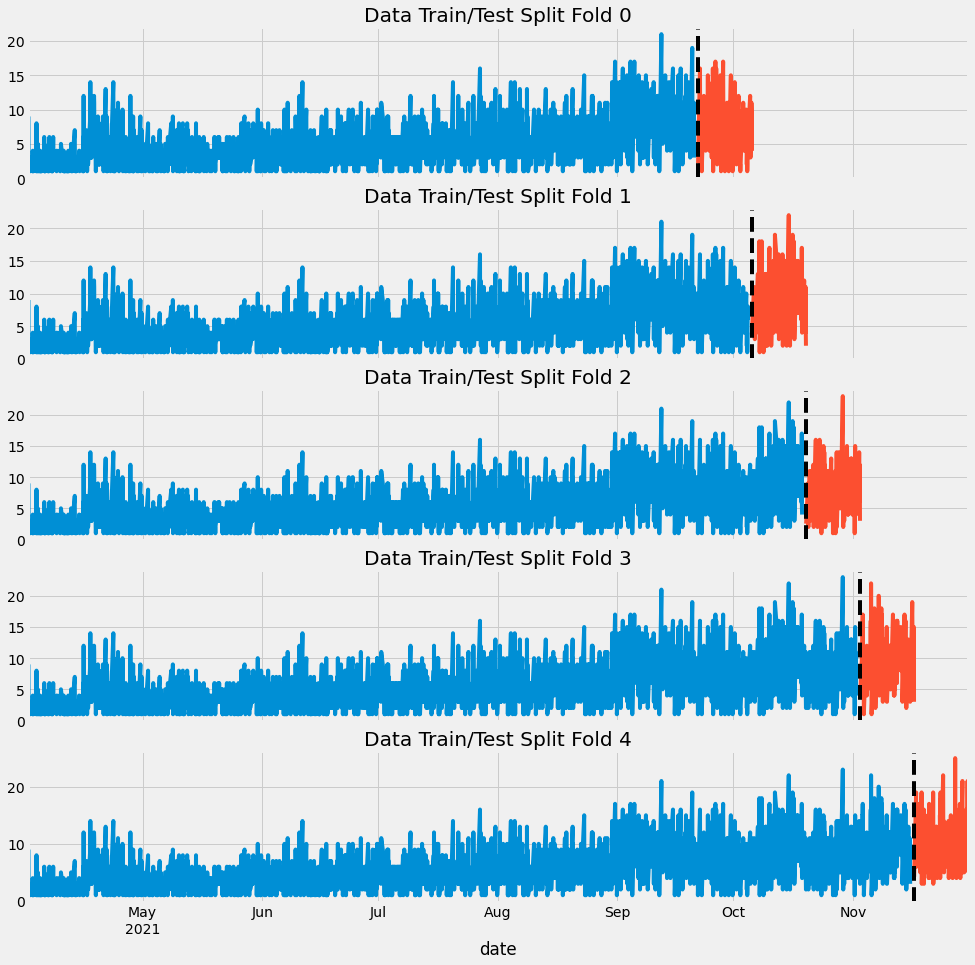

In [175]:
#Графики, показывающие, как происходит разделение на train/test
fig, axs = plt.subplots(5, 1, figsize=(15, 15), 
                        sharex=True)
fold = 0
for train_index, test_index in tscv.split(df):
  train = df.iloc[train_index]
  test = df.iloc[test_index]
  train['orders_cnt'].plot(ax=axs[fold], 
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
  test['orders_cnt'].plot(ax=axs[fold], 
                          label='Test Set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold += 1
plt.show()

In [176]:
#Retrain on all data
FEATURES = ['hour', 'dayofweek', 'quarter',
      'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Holidays',
      'early_late_h', 'weekend', 'days_until_holiday', 'days_since_holiday',
      'lag1', 'lag2', 'lag3']
TARGET = 'orders_cnt'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                      n_estimators=1000,
                      early_stopping_rounds=50,
                      objective='reg:linear',
                      max_depth=3,
                      learning_rate=0.01)
reg.fit(X_all, y_all,
      eval_set=[(X_all, y_all)],
      verbose=100)


[17:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.61937
[100]	validation_0-rmse:3.42651
[200]	validation_0-rmse:2.61304
[300]	validation_0-rmse:2.40475
[400]	validation_0-rmse:2.33287
[500]	validation_0-rmse:2.29093
[600]	validation_0-rmse:2.26043
[700]	validation_0-rmse:2.23798
[800]	validation_0-rmse:2.21622
[900]	validation_0-rmse:2.19496
[999]	validation_0-rmse:2.17651


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

In [177]:
df.index.max()

Timestamp('2021-11-30 21:00:00', freq='H')

In [263]:
#Create future preds
future = pd.date_range('2021-11-30 22:00:00', '2021-12-07 21:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future.index.name = 'date'

In [264]:
df_and_future = df_and_future.drop(columns=['days_until_holiday', 'days_since_holiday'])
df_and_future = before_after_holiday(df_and_future)
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [267]:
future_w_features = df_and_future.query('isFuture').copy()

In [268]:
#Predict the future
future_w_features['prediction'] = reg.predict(future_w_features[FEATURES])

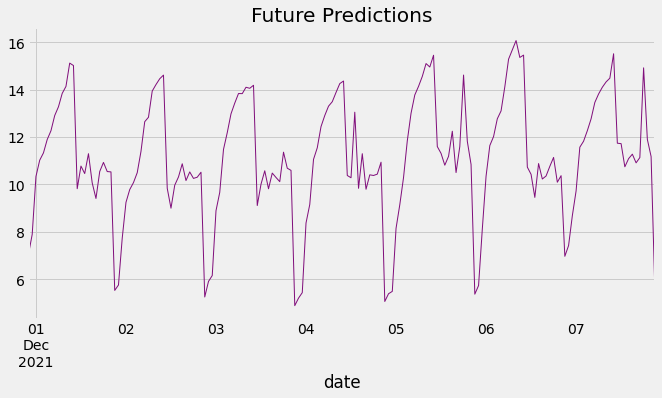

In [272]:
future_w_features['prediction'].plot(figsize=(10, 5), 
                                     color=color_pal[5],
                                     ms=1,
                                     lw=1,
                                     title='Future Predictions')
plt.show()

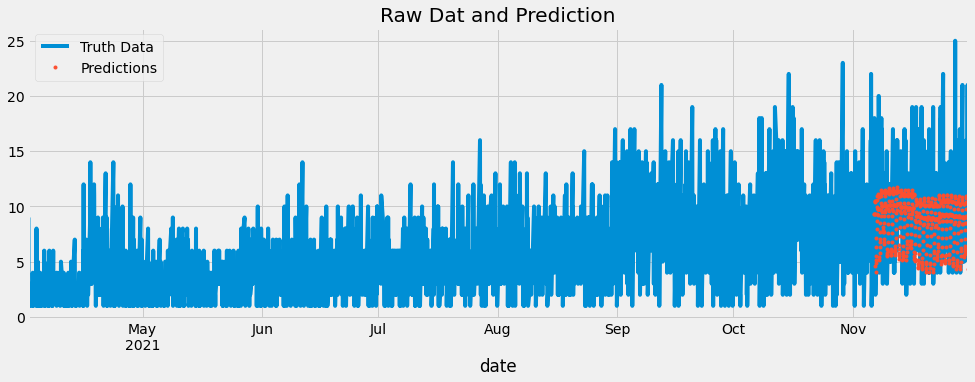

In [71]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['orders_cnt']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

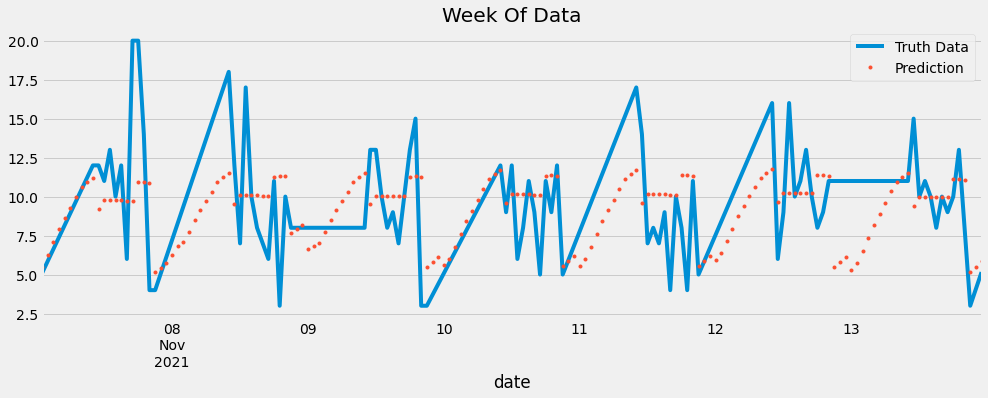

In [72]:
ax = df.loc[(df.index > '11-07-2021') & (df.index < '11-14-2021')]['orders_cnt'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '11-07-2021') & (df.index < '11-14-2021')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [73]:
score = np.sqrt(mean_squared_error(test['orders_cnt'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3.38


In [74]:
test

,delivery_area_id,orders_cnt,days_until_holiday,days_since_holiday,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Holidays,early_late_h,weekend,prediction
date,,,,,,,,,,,,,,,,
2021-11-06 14:00:00,0,8.0,0,0,14,5,4,11,2021,310,6,44,1,0,1,9.346270
2021-11-06 15:00:00,0,18.0,0,0,15,5,4,11,2021,310,6,44,1,0,1,9.346270
2021-11-06 16:00:00,0,8.0,0,0,16,5,4,11,2021,310,6,44,1,0,1,9.333077
2021-11-06 17:00:00,0,6.0,0,0,17,5,4,11,2021,310,6,44,1,0,1,9.333077
2021-11-06 18:00:00,0,6.0,0,0,18,5,4,11,2021,310,6,44,1,0,1,10.490078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 17:00:00,0,10.0,30,23,17,1,4,11,2021,334,30,48,0,0,0,9.056229
2021-11-30 18:00:00,0,21.0,30,23,18,1,4,11,2021,334,30,48,0,0,0,10.264131
2021-11-30 19:00:00,0,10.0,30,23,19,1,4,11,2021,334,30,48,0,0,0,10.290517


In [75]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date_only'] = test.index.date
test.groupby(['date_only'])['error'].mean().sort_values(ascending=False).head(10)

date_only
2021-11-24    4.452408
2021-11-17    3.881139
2021-11-29    3.461892
2021-11-06    3.438288
2021-11-30    3.279690
2021-11-23    3.278035
2021-11-16    3.195790
2021-11-27    3.040899
2021-11-08    2.987645
2021-11-11    2.943544
Name: error, dtype: float64